# LSTM TCC

Installing the missing libraries (w.r.t. Kaggle).

In [1]:
!pip install keras_preprocessing

Importing libraries.

In [2]:
import sys, os, re, csv, codecs, numpy as np, pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from tensorflow import keras
from keras.preprocessing.text import Tokenizer
from keras_preprocessing.sequence import pad_sequences
from keras.layers import Dense, Input, LSTM, Embedding, Dropout, Activation
from keras.layers import Bidirectional, GlobalMaxPool1D
from keras.models import Model
from keras import initializers, regularizers, constraints, optimizers, layers
from sklearn import metrics
import torchmetrics
import torch

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.23.5
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: l

Loading the datasets.

In [3]:
train = pd.read_csv('/kaggle/input/tcc-input/train.csv')
test = pd.read_csv('/kaggle/input/tcc-input/test.csv')
test_labels = pd.read_csv('/kaggle/input/tcc-input/test_labels.csv')

Splitting the training set into X and Y sets, where X contains the comments and Y the dependent variables.

In [4]:
label_cols = ['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']
y = train[label_cols].values
list_sentences_train = train["comment_text"]
list_sentences_test = test["comment_text"]

Data Pre-processing:
1. Tokenization - Break down the sentence into unique words (e.g., "We must turn right and then turn left" will become ["We", "must", "turn", "right", "and", "then", "turn", "left"]).
2. Indexing - Put the words in a dictionary-like structure and give them an index (e.g., {1:"We",2:"must",3:"turn",4:"right",5:"and", 6:"then", 7:"left"}).
3. Index Representation- Represent the sequence of words in the comments in the form of index, and feed this chain of index into the LSTM (e.g., [1,2,3,4,5,6,3,7]).
4. Padding - Make the shorter sentences as long as the others by filling the shortfall by zeros and trim the longer ones to the same length (maxlen) as the short ones (the LSTM requires a stream of data that has a consistent length, i.e., a fixed number of features); a smaller maxlen could result in the loss of some useful feature, while a greater maxlen requires the LSTM cells to be larger to store the possible values or states.

In [5]:
max_features = 20000 # number of unique words in the dictionary
tokenizer = Tokenizer(num_words=max_features)
tokenizer.fit_on_texts(list(list_sentences_train))
list_tokenized_train = tokenizer.texts_to_sequences(list_sentences_train)
list_tokenized_test = tokenizer.texts_to_sequences(list_sentences_test)

Let's see the distribution of the number of words in the sentences and choose maxlen accordingly.

In [6]:
totalNumWords = [len(one_comment) for one_comment in list_tokenized_train]

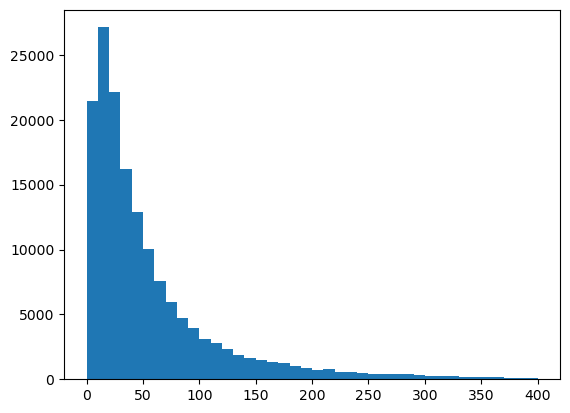

In [7]:
plt.hist(totalNumWords,bins = np.arange(0,410,10)) # [0,50,100,150,200,250,300,350,400])
plt.show()

In [8]:
maxlen = 300
X_t = pad_sequences(list_tokenized_train, maxlen=maxlen)
X_te = pad_sequences(list_tokenized_test, maxlen=maxlen)

## Model Setup

In [9]:
inp = Input(shape=(maxlen, )) # define an Input layer that accepts a list of sentences that has a dimension of maxlen

An Embedding layer projects the words to a defined vector space depending on the distance of the surrounding words in a sentence. Embedding allows to reduce the model size and most importantly the huge dimensions we have to deal with, in the case of using one-hot encoding to represent the words in our sentence. The output of the Embedding layer is just a list of the coordinates of the words in this vector space, e.g.,  (-81.012) for "right" and  (-80.012) for "left". One could also use the distance of these coordinates to detect relevance and context. The embedding layer outputs a 3-D tensor of (None, maxlen, embed_size), which is an array of sentence, and for each words(maxlen), there is an array of embed_size coordinates in the vector space of embedding. 

In [10]:
embed_size = 128 # size of the vector space
x = Embedding(max_features, embed_size)(inp)

This Tensor is fed into the LSTM layer, set to produce an output that has a dimension of 60 and to return the whole unrolled sequence of results.
LSTM or RNN works by recursively feeding the output of a previous network into the input of the current network, taking the final output after X number of recursion. But some cases, as this one, require to take the unrolled, i.e., the outputs of each recursion as the result to pass to the next layer.

LSTM takes in a tensor of [Batch Size, Time Steps, Number of Inputs], where batch size is the number of samples in a batch, time steps is the number of recursion it runs for each input, and number of inputs is the number of variables.

Specifically, it goes through the samples, recursively running the LSTM model for maxlen times, passing in the coordinates of the words each time, receiving a Tensor shape of (None, maxlen, 60), where 60 is the output dimension previously defined.

In [11]:
x = LSTM(60, return_sequences=True,name='lstm_layer')(x)

Before passing the output to a normal layer, the 3D tensor has to be carefully reshaped into a 2D one, to avoid throwing away relevant data. Resulting data should be a good representative of the original data. To do so, a Global Max Pooling layer, which is traditionally used in CNN problems to reduce the dimensionality of image data, is applyed. In simple terms, it goes through each patch of data, taking the maximum values of each patch. These collection of maximum values will be a new set of down-sized data to be used.


In [12]:
x = GlobalMaxPool1D()(x)

A Dropout layer indiscriminately "disable" some nodes so that the nodes in the next layer is forced to handle the representation of the missing data and the whole network could result in better generalization.

In [13]:
x = Dropout(0.1)(x) # drop out 10% of the nodes

In [14]:
x = Dense(50, activation="relu")(x)

In [15]:
x = Dropout(0.1)(x)

The output is fed into a Sigmoid layer, achieving a binary classification(1,0) for each of the 6 labels (the sigmoid function will squash the output between the bounds of 0 and 1).

In [16]:
x = Dense(6, activation="sigmoid")(x)

## Training

In [17]:
model = Model(inputs=inp, outputs=x)
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

In [18]:
reduce_lr = keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=2, min_lr=0)

In [19]:
batch_size = 32
epochs = 20
model.fit(X_t,y, batch_size=batch_size, epochs=epochs, validation_split=0.1, callbacks = [reduce_lr])

Epoch 1/20
4488/4488 [==============================] - 195s 42ms/step - loss: 0.0675 - binary_accuracy: 0.9780 - val_loss: 0.0498 - val_binary_accuracy: 0.9821 - lr: 0.0010
Epoch 2/20
4488/4488 [==============================] - 78s 17ms/step - loss: 0.0465 - binary_accuracy: 0.9827 - val_loss: 0.0486 - val_binary_accuracy: 0.9824 - lr: 0.0010
Epoch 3/20
4488/4488 [==============================] - 68s 15ms/step - loss: 0.0416 - binary_accuracy: 0.9843 - val_loss: 0.0486 - val_binary_accuracy: 0.9823 - lr: 0.0010
Epoch 4/20
4488/4488 [==============================] - 67s 15ms/step - loss: 0.0373 - binary_accuracy: 0.9854 - val_loss: 0.0490 - val_binary_accuracy: 0.9821 - lr: 0.0010
Epoch 5/20
4488/4488 [==============================] - 68s 15ms/step - loss: 0.0313 - binary_accuracy: 0.9875 - val_loss: 0.0508 - val_binary_accuracy: 0.9819 - lr: 5.0000e-04
Epoch 6/20
4488/4488 [==============================] - 65s 14ms/step - loss: 0.0285 - binary_accuracy: 0.9886 - val_loss: 0.0539 

## Evaluation

In [20]:
preds = model.predict(X_te)

4787/4787 [==============================] - 26s 5ms/step


Rows with -1 values in test_labels are not used for evaluation. Therefore, we remove them from test_labels and predictions.

In [21]:
indexes = []
for index, row in test_labels.iterrows():
    if row['toxic'] == -1:
        indexes.append(index)
test_labels = test_labels.drop(indexes)

In [22]:
test_ids = pd.DataFrame({'id': test["id"]})
predictions = pd.concat([test_ids, pd.DataFrame(preds, columns = label_cols)], axis=1)

Drop rows not used for evaluation.

In [23]:
predictions = predictions.drop(indexes)

Calculating ROC AUC score for each category.

In [24]:
for cat in label_cols:
    
    print(f"Category: {cat}")
    print(f"Sklearn score: {metrics.roc_auc_score(test_labels[cat], predictions[cat], multi_class='ovr')}")
    print(f"torchmetrics score: {torchmetrics.functional.classification.binary_auroc(torch.tensor(predictions[cat].values),torch.tensor(test_labels[cat].values), thresholds=None)}")
    print("#" * 30)
    print()

Category: toxic
Sklearn score: 0.9501547251994906
torchmetrics score: 0.9501547813415527
##############################

Category: severe_toxic
Sklearn score: 0.9794202988815235
torchmetrics score: 0.9794203042984009
##############################

Category: obscene
Sklearn score: 0.9670376145366293
torchmetrics score: 0.967037558555603
##############################

Category: threat
Sklearn score: 0.9741277802176274
torchmetrics score: 0.9741277694702148
##############################

Category: insult
Sklearn score: 0.9591363770034098
torchmetrics score: 0.9591363668441772
##############################

Category: identity_hate
Sklearn score: 0.9639100709790693
torchmetrics score: 0.9639101028442383
##############################



Calculating mean column-wise ROC AUC score on all categories.

In [25]:
print(f"Sklearn score: {metrics.roc_auc_score(test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, predictions[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values, average='macro')}")
print(F"Torchmetrics score: {torchmetrics.functional.classification.multilabel_auroc(torch.tensor(predictions[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values),torch.tensor(test_labels[['toxic', 'severe_toxic', 'obscene', 'threat', 'insult', 'identity_hate']].values),num_labels=6,thresholds=None )}")

Sklearn score: 0.965631144469625
Torchmetrics score: 0.9656311869621277
